Import Libraries

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Generate Synthetic Data

In [5]:
# Simulate data: 10000 entries with server performance metrics
n_samples = 10000

# Generating random server performance metrics
data = pd.DataFrame({
    'cpu_usage': np.random.uniform(0, 100, n_samples),       # CPU usage in percentage
    'memory_usage': np.random.uniform(0, 100, n_samples),    # Memory usage in percentage
    'disk_io': np.random.uniform(0, 1000, n_samples),        # Disk I/O in MB/s
    'network_io': np.random.uniform(0, 1000, n_samples),     # Network I/O in MB/s
    'temperature': np.random.uniform(20, 100, n_samples),    # Server temperature in Celsius
    'time_since_last_maintenance': np.random.uniform(0, 365, n_samples),  # Days since last maintenance
})

# Simulate failure labels: 1 = failure, 0 = no failure
# Assume servers with high CPU, memory, and temperature are more likely to fail
data['failure'] = (data['cpu_usage'] > 85) & (data['memory_usage'] > 80) & (data['temperature'] > 80)
data['failure'] = data['failure'].astype(int)

# Show a snapshot of the data
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cpu_usage                    10000 non-null  float64
 1   memory_usage                 10000 non-null  float64
 2   disk_io                      10000 non-null  float64
 3   network_io                   10000 non-null  float64
 4   temperature                  10000 non-null  float64
 5   time_since_last_maintenance  10000 non-null  float64
 6   failure                      10000 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 547.0 KB
None


Data Preprocessing

In [6]:
# Features and target
X = data.drop('failure', axis=1)
y = data['failure']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model Development – Random Forest

In [7]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for AUC

# Evaluation: Confusion Matrix, Classification Report, and ROC AUC
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_prob)}')


[[2983    0]
 [   2   15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2983
           1       1.00      0.88      0.94        17

    accuracy                           1.00      3000
   macro avg       1.00      0.94      0.97      3000
weighted avg       1.00      1.00      1.00      3000

ROC AUC Score: 0.9999802804125338


Hyperparameter Tuning

In [8]:
# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Fit GridSearch
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print(f'Best parameters: {grid_search.best_params_}')

# Best ROC AUC score
print(f'Best ROC AUC: {grid_search.best_score_}')


Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Best ROC AUC: 0.9999404843136364


Visualize Feature Importance

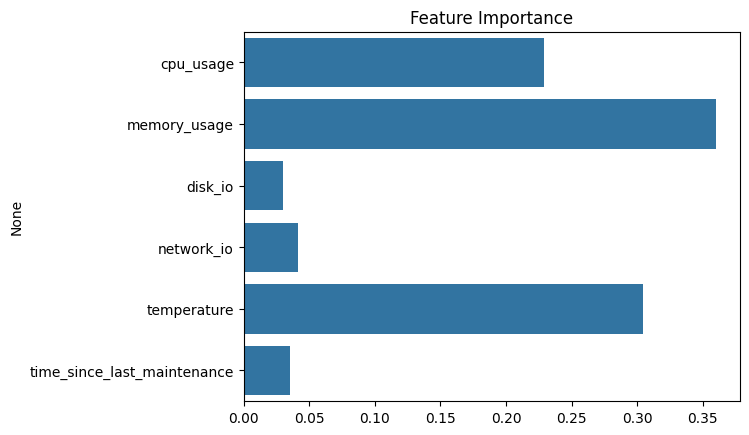

In [11]:
# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns

# Plot feature importance
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()
